# Spring Dataset Stats

To further develop the work we will create a dataset class for Pytorch that we will use to train and test the different models we want to asses. 

Original dataset in h5 format:

https://zenodo.org/record/3746119#.ZCPs7exBwq-

The models for the Spring Reverb modellization are in the following repository:

https://github.com/francescopapaleo/spring-reverb-dl-models.git

### Setup

In [18]:
import os
import random
import numpy as np
import pandas as pd
import torch
import essentia
import essentia.standard as es
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

from src.springset import SpringSet

ImportError: cannot import name 'SpringSet' from 'src.springset' (/Users/francescopapaleo/git-src/virtual-analog-modelling-datasets/src/springset.py)

In [ ]:
seed = 42  # You can choose any seed value
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
# Setting up the directories and the sample rate

DATA_DIR = '../datasets/'
CONVERTED_DIR = "audio/converted"
PROCESSED_DIR = "audio/processed"
MODELS_DIR = "models/"
sample_rate = 16000

## Instantiate the dataset

## Dataset Stats

Compute basic stats and create a dataframe that store the stats for each file. 

In [ ]:
def compute_dataset_details(loader, sample_rate):
    # Number of samples
    num_samples = len(loader.dataset)

    # Compute total duration
    # Assuming each item in the dataset returns a tuple (audio, label) and audio is a 1D tensor
    total_samples_in_dataset = sum([len(audio[0]) for audio, _ in loader.dataset])
    total_duration = total_samples_in_dataset / sample_rate

    # Compute total size in MB
    # Assuming float32 audio representation; 4 bytes per float
    total_size_bytes = total_samples_in_dataset * 4
    total_size_mb = total_size_bytes / (1024 * 1024)

    return num_samples, total_duration, total_size_mb

train_samples, train_duration, train_size_mb = compute_dataset_details(train_loader, sample_rate=sample_rate)  # Assuming 44.1kHz audio
val_samples, val_duration, val_size_mb = compute_dataset_details(valid_loader, sample_rate=sample_rate)
test_samples, test_duration, test_size_mb = compute_dataset_details(test_loader, sample_rate=sample_rate)

print(f"Training Data: {train_samples} samples, {train_duration} seconds, {train_size_mb} MB")
print(f"Validation Data: {val_samples} samples, {val_duration} seconds, {val_size_mb} MB")
print(f"Test Data: {test_samples} samples, {test_duration} seconds, {test_size_mb} MB")

Training Data: 785 samples, 1570.0 seconds, 95.8251953125 MB
Validation Data: 337 samples, 674.0 seconds, 41.1376953125 MB
Test Data: 64 samples, 128.0 seconds, 7.8125 MB


In [ ]:
def compute_stats(loader):
    min_vals_dry, max_vals_dry, mean_vals_dry, std_devs_dry = [], [], [], []
    min_vals_wet, max_vals_wet, mean_vals_wet, std_devs_wet = [], [], [], []
    
    for dry_sample, wet_sample in loader:
        min_vals_dry.append(torch.min(dry_sample).item())
        max_vals_dry.append(torch.max(dry_sample).item())
        mean_vals_dry.append(torch.mean(dry_sample).item())
        std_devs_dry.append(torch.std(dry_sample).item())

        min_vals_wet.append(torch.min(wet_sample).item())
        max_vals_wet.append(torch.max(wet_sample).item())
        mean_vals_wet.append(torch.mean(wet_sample).item())
        std_devs_wet.append(torch.std(wet_sample).item())

    stats = {
        "dry": {
            "number_of_samples": len(min_vals_dry),
            "min": min(min_vals_dry),
            "max": max(max_vals_dry),
            "mean": np.mean(mean_vals_dry),
            "std_dev": np.mean(std_devs_dry),
            
        },
        "wet": {
            "number_of_samples": len(min_vals_wet),
            "min": min(min_vals_wet),
            "max": max(max_vals_wet),
            "mean": np.mean(mean_vals_wet),
            "std_dev": np.mean(std_devs_wet),
        },
    }

    return stats

for split in [train_loader, valid_loader, test_loader]:
    stats = compute_stats(split)
    
    for s in stats:
        for k, v in stats[s].items():
            print(f"{s} {k}: {v:.4f}") 

dry number_of_samples: 785.0000
dry min: -1.0000
dry max: 1.0000
dry mean: -0.0000
dry std_dev: 0.1962
wet number_of_samples: 785.0000
wet min: -1.0000
wet max: 1.0000
wet mean: -0.0000
wet std_dev: 0.2567
dry number_of_samples: 337.0000
dry min: -1.0000
dry max: 1.0000
dry mean: -0.0000
dry std_dev: 0.1987
wet number_of_samples: 337.0000
wet min: -1.0000
wet max: 1.0000
wet mean: 0.0000
wet std_dev: 0.2522
dry number_of_samples: 64.0000
dry min: -1.0000
dry max: 1.0000
dry mean: -0.0000
dry std_dev: 0.1969
wet number_of_samples: 64.0000
wet min: -1.0000
wet max: 1.0000
wet mean: -0.0001
wet std_dev: 0.2588


## Extract audio descriptors to verify that the data is correctly loaded and processed

### Loudness

In [ ]:
def compute_loudness(loader):
    loudness_dry, loudness_wet = [], []
    transform = torchaudio.transforms.Loudness(sample_rate)
    for dry_sample, wet_sample in loader:
        loudness_dry.append(transform(dry_sample).item())
        loudness_wet.append(transform(wet_sample).item())
    return {
        "dry": np.mean(loudness_dry),
        "wet": np.mean(loudness_wet),
    }

loudness = compute_loudness(train_loader)

for k, v in loudness.items():
    print(f"{k} mean loudness: {v:.4f} LUFS")

dry mean loudness: -14.0395 LUFS
wet mean loudness: -11.7744 LUFS


### Spectral Centroid

In [ ]:
def compute_centroids(loader):
    librosa_results = {}
    torch_results = {}
    lib_centr_dry, lib_centr_wet = [], []
    torch_centr_dry, torch_centr_wet = [], []

    transform = torchaudio.transforms.SpectralCentroid(sample_rate)

    for x,y in loader:
        torch_centr_x = transform(x)
        torch_centr_y = transform(y)
    
        torch_centr_dry.append(torch_centr_x.detach().numpy().squeeze())
        torch_centr_wet.append(torch_centr_y.detach().numpy().squeeze())

        x = x.detach().numpy().squeeze()
        y = y.detach().numpy().squeeze()

        # Compute the spectral centroid for the dry and wet sample
        centroid_dry = librosa.feature.spectral_centroid(y=x, sr=16000)[0]
        centroid_wet = librosa.feature.spectral_centroid(y=y, sr=16000)[0]

        # Add the centroid to the respective list
        lib_centr_dry.append(centroid_dry)
        lib_centr_wet.append(centroid_wet)

    librosa_results = {
        "dry": {
            "centroid_mean": np.mean(lib_centr_dry),
            "centroid_std_dev": np.std(lib_centr_dry),
        },
        "wet": {
            "centroid_mean": np.mean(lib_centr_wet),
            "centroid_std_dev": np.std(lib_centr_wet),
        },
    }

    torch_results = {
        "dry": {
            "centroid_mean": np.mean(torch_centr_dry),
            "centroid_std_dev": np.std(torch_centr_dry),
        },
        "wet": {
            "centroid_mean": np.mean(torch_centr_wet),
            "centroid_std_dev": np.std(torch_centr_wet),
        },
    }

    return librosa_results, torch_results


librosa_results, torch_results = compute_centroids(train_loader)


print("Librosa Results:")
for key, values in librosa_results.items():
    print(f"{key.capitalize()} - Centroid Mean: {values['centroid_mean']:.4f}")
    print(f"{key.capitalize()} - Centroid Std Dev: {values['centroid_std_dev']:.4f}")
print()

print("Torch Results:")
for key, values in torch_results.items():
    print(f"{key.capitalize()} - Centroid Mean: {values['centroid_mean']:.4f}")
    print(f"{key.capitalize()} - Centroid Std Dev: {values['centroid_std_dev']:.4f}")

Librosa Results:
Dry - Centroid Mean: 721.1112
Dry - Centroid Std Dev: 797.4358
Wet - Centroid Mean: 769.0389
Wet - Centroid Std Dev: 847.9456

Torch Results:
Dry - Centroid Mean: nan
Dry - Centroid Std Dev: nan
Wet - Centroid Mean: 742.3086
Wet - Centroid Std Dev: 820.4637


### f0 estimation - estimate the number of bass notes

In [ ]:
# Estimate a reasonable threshold for distinguishing between bass and guitar.
# This might need to be adjusted depending on the specifics of the dataset.
f0_threshold = librosa.note_to_hz('E2')  # The E2 note is typically the lowest note on a 4-string bass.
print(f'Threshold set: {f0_threshold}, Hz')

f0s = []
bass_indices = []

for idx, (input, target) in enumerate(train_loader):
    # Get the dry signal
    dry_signal = input.squeeze().numpy()
    
    # Estimate f0 using YIN algorithm
    f0 = librosa.yin(dry_signal, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    
    # Take the median to get a single f0 estimate for the entire clip
    f0_median = np.median(f0)
    f0s.append(f0_median)

    if f0_median <= f0_threshold:
        bass_indices.append(idx)

# Convert list to numpy array
f0s = np.array(f0s)

# Count the number of bass and guitar samples
num_bass_samples = np.sum(f0s <= f0_threshold)
num_guitar_samples = np.sum(f0s > f0_threshold)

print(f"Estimated number of bass samples: {num_bass_samples}")
print(f"Estimated number of guitar samples: {num_guitar_samples}")

print("Index numbers of estimated bass samples:", ", ".join(str(i) for i in bass_indices))

Threshold set: 82.4068892282175, Hz
Estimated number of bass samples: 57
Estimated number of guitar samples: 840
Index numbers of estimated bass samples: 5, 13, 24, 30, 36, 37, 51, 55, 92, 99, 100, 109, 111, 126, 134, 137, 199, 200, 237, 266, 297, 348, 350, 379, 387, 402, 408, 410, 453, 468, 470, 483, 522, 525, 563, 564, 595, 639, 643, 649, 674, 678, 685, 697, 708, 717, 718, 719, 722, 757, 768, 769, 840, 844, 850, 851, 866


## Baselines

For the evaluation of the models we will use the following metrics: MAE, MSE, ESR, SNR.
Here we compute the metrics for the dataset in order to define some ranges.

In [ ]:
# Create the metrics
mae = torch.nn.L1Loss()
esr = auraloss.time.ESRLoss()
dc = auraloss.time.DCLoss()
mrstft = auraloss.freq.MultiResolutionSTFTLoss()

### 'DummyModel'-> Input - Target

First, we compute the metrics for the whole dataset between input and target.

In [ ]:
# Input - Target 
metrics = {'mae': [], 'esr': [], 'dc': [], 'mrstft': []}

for input, target in test_loader:    
    metrics['mae'].append(mae(input, target).item())
    metrics['esr'].append(esr(input, target).item())
    metrics['dc'].append(dc(input, target).item())
    metrics['mrstft'].append(mrstft(input, target).item())

# Convert lists to numpy arrays for easier manipulation
for metric in ['mae','esr', 'dc', 'mrstft']:
    metrics[metric] = np.array(metrics[metric])

# Create a dataframe to store the mean, std, min, and max of each metric
data = {
    metric: [metrics[metric].mean(), metrics[metric].std(), metrics[metric].min(), metrics[metric].max()] 
    for metric in ['mae', 'esr', 'dc', 'mrstft']
}
input_df = pd.DataFrame(data, index=['mean', 'std', 'min', 'max'])

print(input_df)

           mae       esr            dc    mrstft
mean  0.193139  1.396212  5.349136e-06  1.896524
std   0.070434  0.576901  4.203965e-05  0.234194
min   0.068774  0.227750  4.798330e-14  1.505747
max   0.374550  2.975077  3.390221e-04  2.601820


### Noise Ceiling -> White Noise - Target

Then, we compute the metrics for the whole dataset between input and a random tensor.

In [ ]:
# Random
metrics = {'mae': [], 'esr': [], 'dc': [], 'mrstft': []}

# Compute the metrics for the test set
for _, target in test_loader:
    # Generate a white noise input of the same size as your target
    white_noise = torch.randn_like(target)
    
    # Compute the metrics
    metrics['mae'].append(mae(input, target).item())
    metrics['esr'].append(esr(input, target).item())
    metrics['dc'].append(dc(input, target).item())
    metrics['mrstft'].append(mrstft(input, target).item())

# Convert lists to numpy arrays for easier manipulation
for metric in ['mae','esr', 'dc', 'mrstft']:
    metrics[metric] = np.array(metrics[metric])

# Create a dataframe to store the mean and std of each metric
data = {
    metric: [metrics[metric].mean(), metrics[metric].std(), metrics[metric].min(), metrics[metric].max()] 
    for metric in ['mae', 'esr', 'dc', 'mrstft']
}

random_df = pd.DataFrame(data, index=['mean', 'std', 'min', 'max'])

print("random-target reference")
print(random_df)

random-target reference
           mae       esr            dc    mrstft
mean  0.219362  1.921974  5.347407e-06  2.913939
std   0.049186  0.609799  4.201918e-05  0.221517
min   0.141121  1.154159  1.763493e-13  2.243861
max   0.418510  4.677402  3.388576e-04  3.548250


## Comparing with the preliminary results obtained from new trainings 

[GitHub Repo](https://github.com/francescopapaleo/spring-reverb-dl-models) of the Spring Reverb project.

In [ ]:
model_df = pd.read_csv("results/metrics_jul_09.csv")
print(model_df)

        conf_name     criterion       mae       mse       esr        dc  \
0         WN-1500    mrstft+mae  0.041037  0.015766  0.817967  0.000051   
1    LSTM-96-smax    mrstft+mae  0.117293  0.043277  0.999929  0.000006   
2       LSTM-96-1    mrstft+mae  0.117296  0.043279  0.999995  0.000006   
3       LSTM-smax    mrstft+mae  0.117297  0.043279  1.000000  0.000006   
4        LSTM-128    mrstft+mae  0.117297  0.043279  1.000008  0.000006   
5          WN-150  mrstft + mae  0.110782  0.034873  1.208088  0.007148   
6           WN-1k  mrstft + mae  0.120865  0.043301  1.327192  0.000381   
7   LSTM-128-skip    mrstft+mae  0.127849  0.047084  1.652129  0.000029   
8          TCN-4k  mrstft + mae  0.044876  0.017016  1.795108  0.000073   
9         TCN-2k7    mrstft+mae  0.064319  0.029105  2.346519  0.000097   
10         TCN-2k    mrstft+mae  0.071206  0.032597  2.395392  0.000143   
11        TCN-5k4    mrstft+mae  0.041331  0.018924  2.468521  0.000076   
12         TCN-BL  mrstft

In [ ]:
# Create an empty DataFrame to store the deltas
comparison_df = pd.DataFrame()

# For each metric, compute the difference with the random and input reference values
for metric in ['mae', 'esr', 'mrstft']:
    comparison_df[f'{metric}_random_delta'] = model_df[metric] - random_df.loc['mean', metric]
    comparison_df[f'{metric}_input_delta'] = model_df[metric] - input_df.loc['mean', metric]

# # Copy over the model configuration columns
# for column in ['conf_name', 'n_epochs', 'batch_size']:
#     comparison_df[column] = model_df[column]

# # Define the order of the columns
# column_order = ['model_type', 'n_epochs', 'batch_size'] + [col for col in comparison_df.columns if col not in ['model_type', 'n_epochs', 'batch_size']]

# # Reorder the columns
# comparison_df = comparison_df[column_order]

comparison_df

,mae_random_delta,mae_input_delta,esr_random_delta,esr_input_delta,mrstft_random_delta,mrstft_input_delta
0,-0.178325,-0.152101,-1.104007,-0.578245,-2.163780,-1.146365
1,-0.102069,-0.075845,-0.922046,-0.396284,-0.235039,0.782376
2,-0.102066,-0.075842,-0.921979,-0.396217,0.594076,1.611491
3,-0.102066,-0.075842,-0.921974,-0.396212,0.603254,1.620668
4,-0.102065,-0.075842,-0.921967,-0.396205,0.583866,1.601280
5,-0.108580,-0.082357,-0.713886,-0.188124,-1.432744,-0.415329
6,-0.098497,-0.072273,-0.594782,-0.069020,-1.094073,-0.076658
7,-0.091513,-0.065289,-0.269845,0.255917,-1.050664,-0.033249
8,-0.174486,-0.148262,-0.126866,0.398896,-1.962675,-0.945260
9,-0.155043,-0.128820,0.424544,0.950306,-1.920165,-0.902750


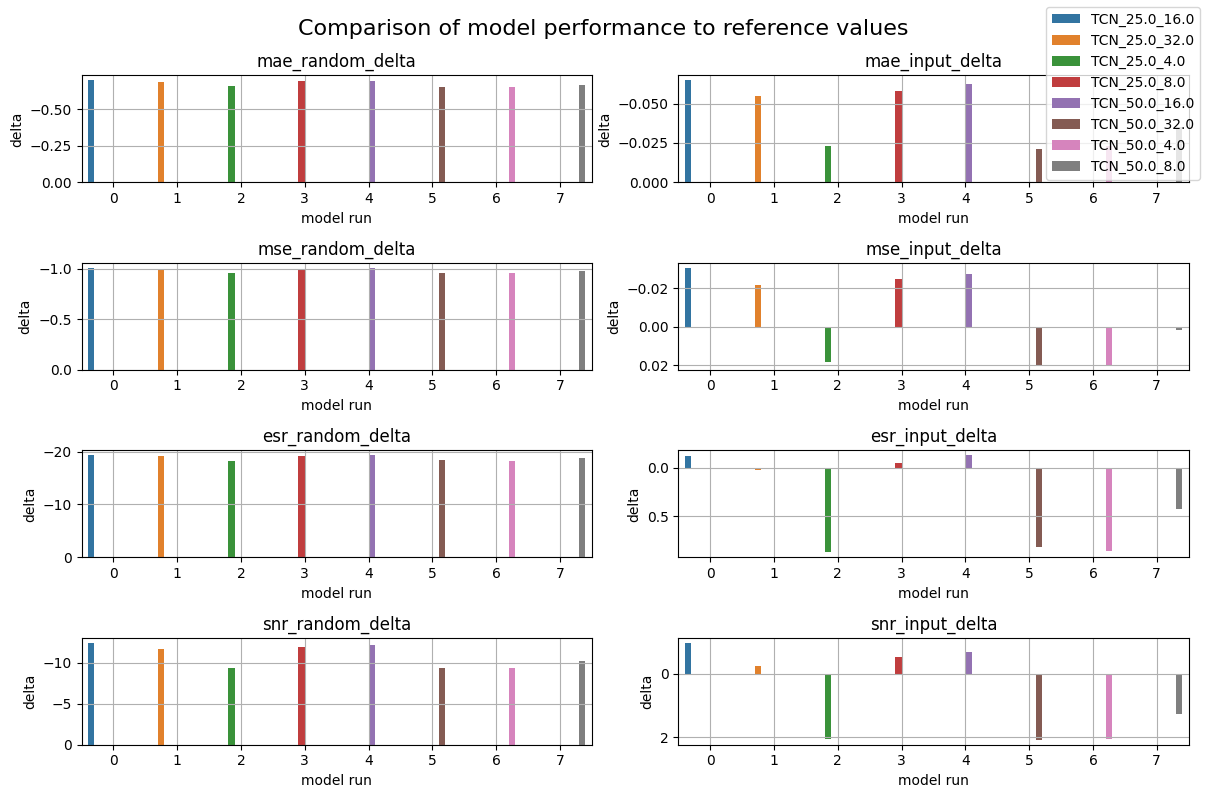

In [ ]:
combined_hue = comparison_df['model_type'].astype(str) + '_' + comparison_df['n_epochs'].astype(str) + '_' + comparison_df['batch_size'].astype(str)

fig, axs = plt.subplots(4, 2, figsize=(12, 8))

# flatten the axes array so you can iterate through it
axs = axs.flatten()

metrics = ['mae_random_delta', 'mae_input_delta', 'mse_random_delta', 'mse_input_delta', 
           'esr_random_delta', 'esr_input_delta', 'snr_random_delta', 'snr_input_delta']

for i, metric in enumerate(metrics):
    sns.barplot(data=comparison_df, x=comparison_df.index, y=metric, hue=combined_hue, ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].grid(True)
    axs[i].get_legend().remove()  # remove the legend from each subplot
    axs[i].set_title(metric)
    axs[i].set_xlabel('model run')
    axs[i].set_ylabel('delta')

# Add a single legend to the last plot
handles, labels = axs[-1].get_legend_handles_labels()  
fig.legend(handles, labels, loc='upper right')
fig.suptitle('Comparison of model performance to reference values', fontsize=16)

# remove any unused subplots
for ax in axs[len(metrics):]:
    ax.remove()

# Ensure subplots do not overlap
plt.tight_layout()
plt.show()